# Learning TF-Slim: extracting features, fine-tuning

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time
from datasets import dataset_utils
from datasets import birds

# Main slim library
slim = tf.contrib.slim

# plot inside the window
%matplotlib inline



# Helper functions
import sklearn.metrics.pairwise
import scipy.spatial.distance

def NormaliseRows(S_te_pro):
    ''' This function normalises the input matrix.
    S_te_pro: input matrix
    
    '''
    S_te_pro_T = np.transpose(S_te_pro)
    normF      = np.sqrt(np.sum(np.multiply(S_te_pro_T,S_te_pro_T), axis = 1))
    normFUsed  = normF
    normFUsed[normFUsed == 0] = 1
    
    for i in range(normFUsed.shape[0]):
        S_te_pro_T[i,:] = S_te_pro_T[i,:]/normFUsed[i]
    return np.transpose(S_te_pro_T)


def knn_zsl_el(a_est_g, S_te_pro, X_te_Y, te_cl_id):
    ''' a_est_g   : [k, N] estimated semantic attribute matrix
        S_te_pro  : [c, k] prototype
        X_te_Y    : [N, 1] ground truth labels
        te_cl_id  : [c,1]  label id
        N         : the number of samples
        k         : attribute dimension size
        c         : the number of classes
        
        Return:
        Acc       : Accuracy
        Y_est     : Estimated labels
    '''
    dist1 = 1 - sklearn.metrics.pairwise.pairwise_distances(np.transpose(a_est_g), NormaliseRows(S_te_pro),'cosine')
    Z_est = [];
    for i in range(len(dist1)):
        I = sorted(range(len(dist1[i,:])), key=lambda k: dist1[i,:][k])
        Z_est.append(te_cl_id[I[-1]])
        
    X_te_Y =X_te_Y[:]
    X_te_Y = np.array(X_te_Y[:])
    Z_est  = np.array(Z_est)

    n=0;
    for i  in range(len(dist1)):
        if (X_te_Y[i] == Z_est[i]):
            n = n + 1;
    
    Acc = float(n)/float(len(dist1))
    #print('{:0.3f}'.format (Acc))
    return Acc, Z_est


# Dataset preparation
import csv
import os
from scipy.misc import imresize

# Path to the image files
PATH        = './CUB/CUB_200_2011_box/images'
files   = [os.path.join(PATH, file_i) for file_i in os.listdir(PATH)]

images = []
with open('./CUB/CUB_200_2011_box/images.txt') as inputfile:
    for row in csv.reader(inputfile):
        images.append(row[0].split(' ')[1])
        
images = np.array(images)

ATTRIBUTES_temp = []
with open('./CUB/CUB_200_2011_box/attributes/class_attribute_labels_continuous.txt') as inputfile:
    for row in csv.reader(inputfile):
        ATTRIBUTES_temp.append(row[0])
ATTRIBUTES_temp = np.array(ATTRIBUTES_temp)

ATTRIBUTES = np.zeros((200, 312))
for i in range(200):
    str1 = ATTRIBUTES_temp[i].split(' ')
    for j, content in enumerate(str1):
        ATTRIBUTES[i,j] = content

### Unseen (Test) classes
test_classes = []
with open('./CUB/CUB_200_2011_box/testclasses_akata.txt') as inputfile:
    for row in csv.reader(inputfile):
        test_classes.append(row)
test_classes = np.array(test_classes)

### Seen (Train) classes
train_classes = []
with open('./CUB/CUB_200_2011_box/trainclasses_akata.txt') as inputfile:
    for row in csv.reader(inputfile):
        train_classes.append(row)
train_classes = np.array(train_classes)


## Read image from the data (*.tfrecord)

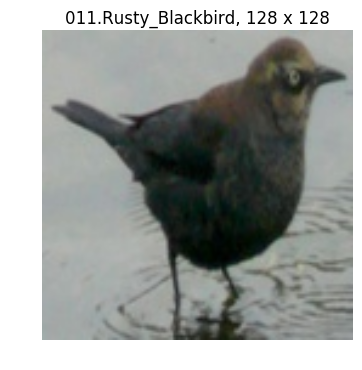

In [3]:
cub_data_dir      = './tmp/cub/'

with tf.Graph().as_default(): 
    dataset       = birds.get_split('train', cub_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in xrange(1):
                np_image, np_label = sess.run([image, label])
                height, width, _   = np_image.shape
                class_name = name  = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

## Download Inception Models

In [4]:
#url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
#url = "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"
url             = "http://download.tensorflow.org/models/inception_v2_2016_08_28.tar.gz"
checkpoints_dir = './tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)
dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

## Apply pretrained model to Images

In [45]:
import os
import urllib2
from PIL import Image
from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

batch_size = 3
image_size = inception.inception_v2.default_image_size
cub_data_dir = './tmp/cub'

with tf.Graph().as_default():
#     url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
#     image_string = urllib2.urlopen(url).read()
#     image = tf.image.decode_jpeg(image_string, channels=3)
#     processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
#     processed_images  = tf.expand_dims(processed_image, 0)
    processed_images = tf.placeholder(tf.float32, shape = (None, 224, 224, 3))
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, endpoints = inception.inception_v2(processed_images, num_classes=1001, is_training=False)
        features = endpoints['Mixed_5c']
        features = slim.avg_pool2d(features, [7,7])
        print features.get_shape()
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v2.ckpt'),
        slim.get_model_variables('InceptionV2'))
    
    with tf.Session() as sess:
        init_fn(sess)
        #np_image, features = sess.run([image, features])
        img1 = Image.open('dog.jpg').resize((224,224))
        img1 = np.array(img1)
        img1 = img1.reshape(-1,224,224,3)
        features = sess.run(features, feed_dict={processed_images: 2*(img1/255.0)-1.0})

print(np.array(features).shape)
tmp = np.array(features)
tmp1 = tmp[0,0,0,:]
print(tmp1.shape)

# Plotting features
plt.plot(tmp1) 

start inception v2
(?, 1, 1, 1024)


## Fine-tune the model on a different set of labels.

We will fine tune the inception model on the CUB dataset.

In [ ]:
#### Note that this may take several minutes.
import os
slim = tf.contrib.slim
import tensorflow as tf
from datasets import birds
from nets import inception
from preprocessing import inception_preprocessing

# Helper function
def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels




#image_size = inception.inception_v1.default_image_size
#image_size = inception.inception_v3.default_image_size
image_size = inception.inception_v2.default_image_size

def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    #checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    #checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]
    checkpoint_exclude_scopes=["InceptionV2/Logits", "InceptionV2/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v2.ckpt'),
      variables_to_restore)


train_dir = './tmp/inception_finetunedv2/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = birds.get_split('train', cub_data_dir)
    print(dataset.num_classes)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    #with slim.arg_scope(inception.inception_v1_arg_scope()):
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, _ = inception.inception_v2(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss     = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.scalar_summary('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps = 10000)
        
print('Finished training. Last batch loss %f' % final_loss)

150
start inception v2
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.


## Feature extraction using fine-tuned model

start inception v2
(?, 1, 1, 1024)
(1, 1, 1, 1024)
(1024,)
[ 0.31726938  0.3094953   0.         ...,  0.41704419  0.08875093
  0.60113984]


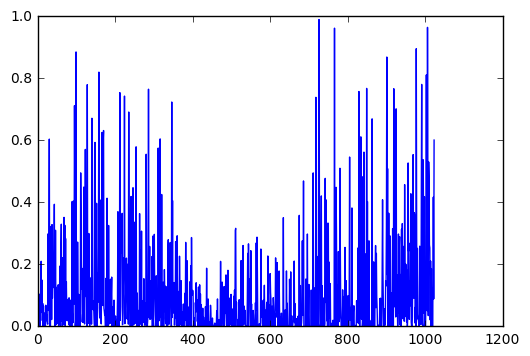

In [87]:
image_size = inception.inception_v2.default_image_size
batch_size = 30

with tf.Graph().as_default(): 
    processed_images = tf.placeholder(tf.float32, shape = (None, 229, 229, 3))
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, endpoints = inception.inception_v2(processed_images, num_classes=dataset.num_classes, is_training=False)
        features = endpoints['Mixed_5c']
        features = slim.avg_pool2d(features, [7,7])
        print features.get_shape()
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        init_fn(sess)
        #np_image, features = sess.run([image, features])
        img1 = Image.open('dog.jpg').resize((229,229))
        img1 = np.array(img1)
        img1 = img1.reshape(-1,229,229,3)
        #features = sess.run(features, feed_dict={processed_images: 2*(img1/255.0)-1.0})
        features = sess.run(features, feed_dict={processed_images: 2*(img1/255.0)-1.0})

print(np.array(features).shape)
tmp = np.array(features)
tmp1 = tmp[0,0,0,:]
print(tmp1.shape)
print(tmp1)
plt.plot(tmp1)

## Apply fine-tuned model to all images
### Training images

In [126]:
## Seen classes
N = 8855 # the number of images for seen classes
k = 1024 # feature dimension
d = 312  # attribute dimension
c = 150   # the number of unseen classes
from scipy.misc import imresize

g = tf.Graph()
with g.as_default(): 
    processed_images = tf.placeholder(tf.float32, shape = (None, 229, 229, 3))
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, endpoints = inception.inception_v2(processed_images, num_classes=dataset.num_classes, is_training=False)
        features = endpoints['Mixed_5c']
        features = slim.avg_pool2d(features, [7,7])
        print features.get_shape()
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())

    imgs_train_fea      = np.zeros((N, k))
    S_train             = np.zeros((N, d))
    index_counter_train = 0
    
    with tf.Session() as sess:
        init_fn(sess)

        for i in range(c): #150
            print(index_counter_train)
            for j in range(images.shape[0]):
                if (images[j].split('/')[0] == train_classes[i][0].split(' ')[1]):
                    #print(os.path.join(PATH, images[j]))
                    im = plt.imread(os.path.join(PATH, images[j]));
                    im_shape_length = len(im.shape)

                    # if the image does not have 3 chanells 
                    if im_shape_length == 2:
                        im_temp = np.zeros((im.shape[0], im.shape[1], 3))

                        im_temp[:,:, 0]  = im
                        im_temp[:,:, 1]  = im
                        im_temp[:,:, 2]  = im

                        img = im_temp
                        img = imresize(img, (229, 229))            
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_train_fea[index_counter_train, :] = fea        
                    else:     
                        img = im
                        img = imresize(img, (229, 229))
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_train_fea[index_counter_train, :] = fea

                    S_train[index_counter_train, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
                    index_counter_train += 1




start inception v2
(?, 1, 1, 1024)
0
60
118
162
215
275
335
391
451
509
567
624
669
728
787
847
903
955
1015
1075
1135
1194
1254
1307
1366
1426
1486
1546
1606
1666
1726
1786
1846
1906
1966
2026
2086
2146
2206
2264
2324
2383
2443
2503
2563
2623
2673
2733
2793
2853
2913
2973
3033
3093
3150
3210
3270
3329
3389
3449
3509
3569
3629
3689
3749
3809
3869
3929
3989
4048
4108
4168
4228
4277
4337
4396
4456
4516
4576
4636
4686
4745
4805
4864
4924
4984
5044
5104
5163
5222
5281
5341
5401
5461
5521
5581
5641
5701
5761
5821
5881
5941
5999
6059
6119
6179
6239
6299
6359
6418
6478
6529
6589
6648
6708
6768
6827
6887
6947
7006
7066
7126
7186
7246
7305
7364
7424
7484
7544
7604
7664
7724
7784
7844
7900
7959
8018
8078
8138
8198
8258
8316
8376
8436
8496
8556
8616
8675
8735
8795


### Test images

In [127]:
from scipy.misc import imresize

# Unseen classes
N = 2933 # the number of images for seen classes
k = 1024 # feature dimension
d = 312  # attribute dimension
c = 50   # the number of unseen classes
imgs_test_fea      = np.zeros((N, k))
imgs_test          = np.zeros((N, k, ))
S_test             = np.zeros((N, d))
Y_test             = []
index_counter_test = 0

from scipy.misc import imresize

g = tf.Graph()
with g.as_default(): 
    processed_images = tf.placeholder(tf.float32, shape = (None, 229, 229, 3))
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, endpoints = inception.inception_v2(processed_images, num_classes=dataset.num_classes, is_training=False)
        features = endpoints['Mixed_5c']
        features = slim.avg_pool2d(features, [7,7])
        print features.get_shape()
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    
    with tf.Session() as sess:
        init_fn(sess)
        for i in range(c):
            print(index_counter_test)
            for j in range(images.shape[0]):
                if (images[j].split('/')[0] == test_classes[i]):
                    #print(os.path.join(PATH, images[j]))
                    im = plt.imread(os.path.join(PATH, images[j]));
                    im_shape_length = len(im.shape)
                    if im_shape_length == 2:

                        im_temp = np.zeros((im.shape[0], im.shape[1], 3))

                        im_temp[:,:, 0]  = im
                        im_temp[:,:, 1]  = im
                        im_temp[:,:, 2]  = im

                        img = im_temp
                        img = imresize(img, (229, 229))        
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_test_fea[index_counter_test, :] = fea        
                    else:     
                        img =  im
                        img = imresize(img, (229, 229))        
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_test_fea[index_counter_test, :] = fea

                    Y_test.append(int(images[j][0:3])-1)
                    #print(int(images[j][0:3])-1)
                    S_test[index_counter_test, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
                    index_counter_test += 1
        

start inception v2
(?, 1, 1, 1024)
0
60
120
161
209
268
328
387
447
507
566
625
685
745
804
864
923
983
1043
1103
1163
1223
1283
1343
1396
1456
1516
1576
1636
1696
1746
1806
1866
1926
1986
2045
2105
2165
2224
2284
2344
2404
2464
2524
2583
2643
2703
2763
2823
2873


## Zero-shot classification: Fine-tuned model

In [134]:
from numpy.linalg import inv
# plt.figure(figsize = (10,30))
# plt.imshow(imgs_test_fea)
# Solving |XW-Y|_F^2 + |W|_F^2 to learn embedding function W
# W = (X^TX + lambda*I)^{-1}X^TS, this is a well-known closed form solution for ridge regression
XtX = np.matmul(np.transpose(imgs_train_fea), imgs_train_fea)
XtS = np.matmul(np.transpose(imgs_train_fea), S_train)
W   = np.matmul(inv(XtX + .000000500 * np.eye(k)), XtS)

S_test_proto = []
te_cl_id     = []

for a_i in test_classes:
    a_i_ind = int(a_i[0][0:3])-1
    S_test_proto.append(ATTRIBUTES[a_i_ind,:])
    te_cl_id.append(a_i_ind)

# Projection to embedding space
S_est      = np.matmul((imgs_test_fea), W)
Acc, Y_est = knn_zsl_el(np.transpose(NormaliseRows( S_est)), (np.array(S_test_proto)), np.array(Y_test),  np.array(te_cl_id))

print(Acc)

0.09103307194


## Pretrained inception V2
### Trainning images

In [75]:
## Seen classes
N = 8855 # the number of images for seen classes
k = 1024 # feature dimension
d = 312  # attribute dimension
c = 150   # the number of unseen classes
from scipy.misc import imresize

g = tf.Graph()
with g.as_default(): 
    processed_images = tf.placeholder(tf.float32, shape = (None, 224, 224, 3))
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, endpoints = inception.inception_v2(processed_images, num_classes=1001, is_training=False)
        features = endpoints['Mixed_5c']
        features = slim.avg_pool2d(features, [7,7])
        print features.get_shape()
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v2.ckpt'),
        slim.get_model_variables('InceptionV2'))

    imgs_train_fea      = np.zeros((N, k))
    S_train             = np.zeros((N, d))
    index_counter_train = 0
    
    with tf.Session() as sess:
        init_fn(sess)

        for i in range(c): #150
            print(index_counter_train)
            for j in range(images.shape[0]):
                if (images[j].split('/')[0] == train_classes[i][0].split(' ')[1]):
                    #print(os.path.join(PATH, images[j]))
                    im = plt.imread(os.path.join(PATH, images[j]));
                    im_shape_length = len(im.shape)

                    # if the image does not have 3 chanells 
                    if im_shape_length == 2:
                        im_temp = np.zeros((im.shape[0], im.shape[1], 3))

                        im_temp[:,:, 0]  = im
                        im_temp[:,:, 1]  = im
                        im_temp[:,:, 2]  = im

                        img = im_temp
                        img = imresize(img, (224, 224))            
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_train_fea[index_counter_train, :] = fea        
                    else:     
                        img = im
                        img = imresize(img, (224, 224))
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_train_fea[index_counter_train, :] = fea

                    S_train[index_counter_train, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
                    index_counter_train += 1




start inception v2
(?, 1, 1, 1024)
0
60
118
162
215
275
335
391
451
509
567
624
669
728
787
847
903
955
1015
1075
1135
1194
1254
1307
1366
1426
1486
1546
1606
1666
1726
1786
1846
1906
1966
2026
2086
2146
2206
2264
2324
2383
2443
2503
2563
2623
2673
2733
2793
2853
2913
2973
3033
3093
3150
3210
3270
3329
3389
3449
3509
3569
3629
3689
3749
3809
3869
3929
3989
4048
4108
4168
4228
4277
4337
4396
4456
4516
4576
4636
4686
4745
4805
4864
4924
4984
5044
5104
5163
5222
5281
5341
5401
5461
5521
5581
5641
5701
5761
5821
5881
5941
5999
6059
6119
6179
6239
6299
6359
6418
6478
6529
6589
6648
6708
6768
6827
6887
6947
7006
7066
7126
7186
7246
7305
7364
7424
7484
7544
7604
7664
7724
7784
7844
7900
7959
8018
8078
8138
8198
8258
8316
8376
8436
8496
8556
8616
8675
8735
8795


### Test images

In [77]:
from scipy.misc import imresize

# Unseen classes
N = 2933 # the number of images for seen classes
k = 1024 # feature dimension
d = 312  # attribute dimension
c = 50   # the number of unseen classes
imgs_test_fea      = np.zeros((N, k))
imgs_test          = np.zeros((N, k, ))
S_test             = np.zeros((N, d))
Y_test             = []
index_counter_test = 0

from scipy.misc import imresize

g = tf.Graph()
with g.as_default(): 
    processed_images = tf.placeholder(tf.float32, shape = (None, 224, 224, 3))
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v2_arg_scope()):
        logits, endpoints = inception.inception_v2(processed_images, num_classes=1001, is_training=False)
        features = endpoints['Mixed_5c']
        features = slim.avg_pool2d(features, [7,7])
        print features.get_shape()
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v2.ckpt'),
        slim.get_model_variables('InceptionV2'))
    
    
    with tf.Session() as sess:
        init_fn(sess)
        for i in range(c):
            print(index_counter_test)
            for j in range(images.shape[0]):
                if (images[j].split('/')[0] == test_classes[i]):
                    #print(os.path.join(PATH, images[j]))
                    im = plt.imread(os.path.join(PATH, images[j]));
                    im_shape_length = len(im.shape)
                    if im_shape_length == 2:

                        im_temp = np.zeros((im.shape[0], im.shape[1], 3))

                        im_temp[:,:, 0]  = im
                        im_temp[:,:, 1]  = im
                        im_temp[:,:, 2]  = im

                        img = im_temp
                        img = imresize(img, (224, 224))        
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_test_fea[index_counter_test, :] = fea        
                    else:     
                        img =  im
                        img = imresize(img, (224, 224))        
                        fea = sess.run(features, feed_dict={processed_images: 2*(img[np.newaxis]/255.0)-1.0})
                        imgs_test_fea[index_counter_test, :] = fea

                    Y_test.append(int(images[j][0:3])-1)
                    #print(int(images[j][0:3])-1)
                    S_test[index_counter_test, :] = ATTRIBUTES[int(images[j][0:3])-1, :]
                    index_counter_test += 1
        

start inception v2
(?, 1, 1, 1024)
0
60
120
161
209
268
328
387
447
507
566
625
685
745
804
864
923
983
1043
1103
1163
1223
1283
1343
1396
1456
1516
1576
1636
1696
1746
1806
1866
1926
1986
2045
2105
2165
2224
2284
2344
2404
2464
2524
2583
2643
2703
2763
2823
2873


## Zero-shot classification: pretrained model

In [85]:
from numpy.linalg import inv
# plt.figure(figsize = (10,30))
# plt.imshow(imgs_test_fea)
# Solving |XW-Y|_F^2 + |W|_F^2 to learn embedding function W
# W = (X^TX + lambda*I)^{-1}X^TS, this is a well-known closed form solution for ridge regression
XtX = np.matmul(np.transpose(imgs_train_fea), imgs_train_fea)
XtS = np.matmul(np.transpose(imgs_train_fea), S_train)
W   = np.matmul(inv(XtX + 10 * np.eye(k)), XtS)

S_test_proto = []
te_cl_id     = []

for a_i in test_classes:
    a_i_ind = int(a_i[0][0:3])-1
    S_test_proto.append(ATTRIBUTES[a_i_ind,:])
    te_cl_id.append(a_i_ind)

# Projection to embedding space
S_est      = np.matmul((imgs_test_fea), W)
Acc, Y_est = knn_zsl_el(np.transpose(NormaliseRows(S_est)), (np.array(S_test_proto)), np.array(Y_test),  np.array(te_cl_id))

print(Acc, '\n', Y_est)

(0.38288441868394135, '\n', array([ 71,  71,  71, ..., 101, 118, 162]))
